In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

In [2]:
df = pd.read_csv('MVP_Candidates.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [3]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-09', '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02', '2000-01', '1999-00')
e3 = ('1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '2021-22') | (df['Year'] == '2020-21') | (df['Year'] == '2019-20') | (df['Year'] == '2018-19') | (df['Year'] == '2017-18') | (df['Year'] == '2016-17') | (df['Year'] == '2015-16') | (df['Year'] == '2014-15') | (df['Year'] == '2013-14') | (df['Year'] == '2012-13')]


In [4]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,125,125,Kevin Garnett,C,5,36,BOS,68,68,16,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,126,126,Marc Gasol,C,5,28,MEM,80,80,6,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,127,127,Ty Lawson,PG,1,25,DEN,73,71,4,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,128,128,David Lee,PF,4,29,GSW,79,79,10,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [5]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)

In [6]:
df1['6.3P+'][108] = 0
''' WHY WAS THIS NaN I HAVE NO CLUE - FILLNA SHOULD HAVE MADE IT ZERO '''
''' ANYWAY PROBLEM SOLVED '''

' ANYWAY PROBLEM SOLVED '

In [7]:
df1.to_csv('ModernEra.csv', index=False)

In [8]:
df1

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,0.621951,2204,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,Devin Booker,SG,2,25,PHO,68,68,1,0.780488,2345,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,Luka Dončić,PG,1,22,DAL,65,65,5,0.634146,2301,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Kevin Garnett,C,5,36,BOS,68,68,16,0.506173,2022,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,Marc Gasol,C,5,28,MEM,80,80,6,0.682927,2796,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,Ty Lawson,PG,1,25,DEN,73,71,4,0.695122,2513,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,David Lee,PF,4,29,GSW,79,79,10,0.573171,2907,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [9]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [10]:
seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13']

In [11]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [12]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [13]:
for season in seasons:
    
    testing_data = df1[(df1['Year'] == season)].copy()
    training_data = df1[(df1['Year'] != season)].copy()
    X_train = training_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    Y_train = training_data['MVP Share']
    X_test = testing_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    Y_test = testing_data['MVP Share']

    X_train.fillna(0)
    X_test.fillna(0)

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    final_params = []

    param_grid = {'n_estimators': [10,20,30,40,50],
                    'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                    'max_depth': [3,4,5]}
    gb_model = GradientBoostingRegressor()
    grid = GridSearchCV(gb_model, param_grid)
    grid.fit(scaled_X_train, Y_train)
    model = GradientBoostingRegressor(**grid.best_params_)
    final_params.append(grid.best_params_)

    model.fit(scaled_X_train, Y_train)

    Y_pred = model.predict(scaled_X_test)

    rmse, r2 = calc_metrics(Y_test, Y_pred)

    season_metrics[season] += [rmse, r2]

    initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
    results = initial_results.copy()
    results['Predicted MVP Share'] = pd.Series(Y_pred).values
    results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

    print(results)

    all_results = pd.concat([all_results, results])

       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875         1             0.850983
1   2021-22  Giannis Antetokounmpo      0.595         3             0.638652
2   2021-22            Joel Embiid      0.706         2             0.514663
3   2021-22            Luka Dončić      0.146         5             0.208283
4   2021-22           LeBron James      0.001        10             0.146237
5   2021-22           Kevin Durant      0.001        10             0.120022
6   2021-22          DeMar DeRozan      0.001        10             0.090305
7   2021-22              Ja Morant      0.010         7             0.088547
8   2021-22          Stephen Curry      0.004         8             0.055622
9   2021-22           Devin Booker      0.216         4             0.043352
10  2021-22           Jayson Tatum      0.043         6             0.042542
11  2021-22             Chris Paul      0.002         9             0.040680

In [14]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

2021-22
RMSE =  0.10260960681946546
R2 =  0.8876632422907419

2020-21
RMSE =  0.1273370195482206
R2 =  0.7979312188801307

2019-20
RMSE =  0.2508114698919475
R2 =  0.3177653502387655

2018-19
RMSE =  0.15003360086955603
R2 =  0.7546435083114775

2017-18
RMSE =  0.161911879201305
R2 =  0.7110259769427906

2016-17
RMSE =  0.12385660406722052
R2 =  0.8434130782794149

2015-16
RMSE =  0.2569355536429823
R2 =  0.30428085026965956

2014-15
RMSE =  0.2144912676155623
R2 =  0.4945174602818817

2013-14
RMSE =  0.11032032420175267
R2 =  0.8385094483841116

2012-13
RMSE =  0.10864479176130973
R2 =  0.8453934174973896



In [15]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.16462054389188185
R2 =  0.6929241796304473


In [16]:
print(all_results.to_string())

       Year                 Player MVP Share MVP Rank Predicted MVP Share
0   2021-22           Nikola Jokić     0.875        1            0.850983
1   2021-22  Giannis Antetokounmpo     0.595        3            0.638652
2   2021-22            Joel Embiid     0.706        2            0.514663
3   2021-22            Luka Dončić     0.146        5            0.208283
4   2021-22           LeBron James     0.001       10            0.146237
5   2021-22           Kevin Durant     0.001       10            0.120022
6   2021-22          DeMar DeRozan     0.001       10            0.090305
7   2021-22              Ja Morant      0.01        7            0.088547
8   2021-22          Stephen Curry     0.004        8            0.055622
9   2021-22           Devin Booker     0.216        4            0.043352
10  2021-22           Jayson Tatum     0.043        6            0.042542
11  2021-22             Chris Paul     0.002        9             0.04068
0   2020-21           Nikola Jokić    

In [17]:
df_test = pd.read_csv("2023_Candidates.csv")
mvpvoting = pd.read_csv("2023_MVP_Voting.csv")
col_to_drop = []
for i in df_test.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)
test2023 = df_test.drop(['Rk', 'Player', 'Pos', 'Pos_No', 'Age', 'Tm'] + col_to_drop, axis=1)

In [18]:
test2023

,G,GS,Seed,Win %,1.MP,1.FG,1.FGA,1.3P,1.3PA,1.2P,...,6.FG+,6.2P+,6.3P+,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add
0,75,75,13,0.536585,2598,602,1114,1,12,601,...,114,100,23,99,103,102,135,3,-9.8,28.3
1,63,63,1,0.707317,2024,707,1278,47,171,660,...,116,109,76,105,83,104,227,35,67.3,78.4
2,68,68,8,0.573171,2379,587,1195,134,322,453,...,103,95,115,100,106,103,123,70,4.8,43.3
3,64,64,13,0.536585,2138,479,888,36,103,443,...,113,103,97,103,109,111,235,30,25.6,149.8
4,56,56,11,0.536585,1941,559,1133,273,639,286,...,104,106,118,113,117,113,93,146,155.5,187.1
5,56,54,14,0.524390,1904,542,962,19,74,523,...,119,107,71,105,100,108,173,20,53.9,105.6
6,74,74,19,0.487805,2682,657,1303,46,142,611,...,106,96,90,96,112,102,151,28,-60.9,33.7
7,66,66,21,0.463415,2391,719,1449,185,541,534,...,104,107,95,103,95,105,180,96,42.9,98.5
8,66,66,3,0.658537,2284,728,1328,66,200,662,...,115,107,91,105,110,113,218,39,73.8,244.8
9,73,73,7,0.585366,2435,682,1331,119,367,563,...,108,107,90,102,100,103,124,71,31.5,53.6


In [19]:
scaled_test2023 = scaler.transform(test2023)

In [20]:
pred2023 = model.predict(scaled_test2023)
result = pd.DataFrame(columns = ['Player', 'Predicted MVP Share'])
result['Player'] = df_test['Player']
result['Predicted MVP Share'] = pd.Series(pred2023).values
result = result.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
result['Predicted MVP Rank'] = result.index + 1
result

,Player,Predicted MVP Share,Predicted MVP Rank
0,Nikola Jokić,0.776285,1
1,Luka Dončić,0.479133,2
2,Joel Embiid,0.389987,3
3,Giannis Antetokounmpo,0.285156,4
4,Jimmy Butler,0.191223,5
5,Anthony Davis,0.125154,6
6,Jayson Tatum,0.064250,7
7,Donovan Mitchell,0.055966,8
8,De'Aaron Fox,0.044399,9
9,Shai Gilgeous-Alexander,0.043495,10


In [21]:
'''SHAP VARIABLE ANALYSIS - 2021-22 SEASON'''

testing_data = df1[(df1['Year'] == '2021-22')].copy()
training_data = df1[(df1['Year'] != '2021-22')].copy()
X_train = training_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
Y_train = training_data['MVP Share']
X_test = testing_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
Y_test = testing_data['MVP Share']

X_train.fillna(0)
X_test.fillna(0)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

final_params = []

param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                'kernel': ['linear','rbf','poly'],
                'gamma': ['scale','auto'],
                'degree': [2,3,4],
                'epsilon': [0.1,0.5,1]}
svr_model = SVR()
grid = GridSearchCV(svr_model, param_grid)
grid.fit(scaled_X_train, Y_train)
model = SVR(**grid.best_params_)
final_params.append(grid.best_params_)

model.fit(scaled_X_train, Y_train)
#Y_pred = model.predict(scaled_X_test)

explainer = shap.Explainer(model.predict, scaled_X_test)
shap_values = explainer(scaled_X_test)

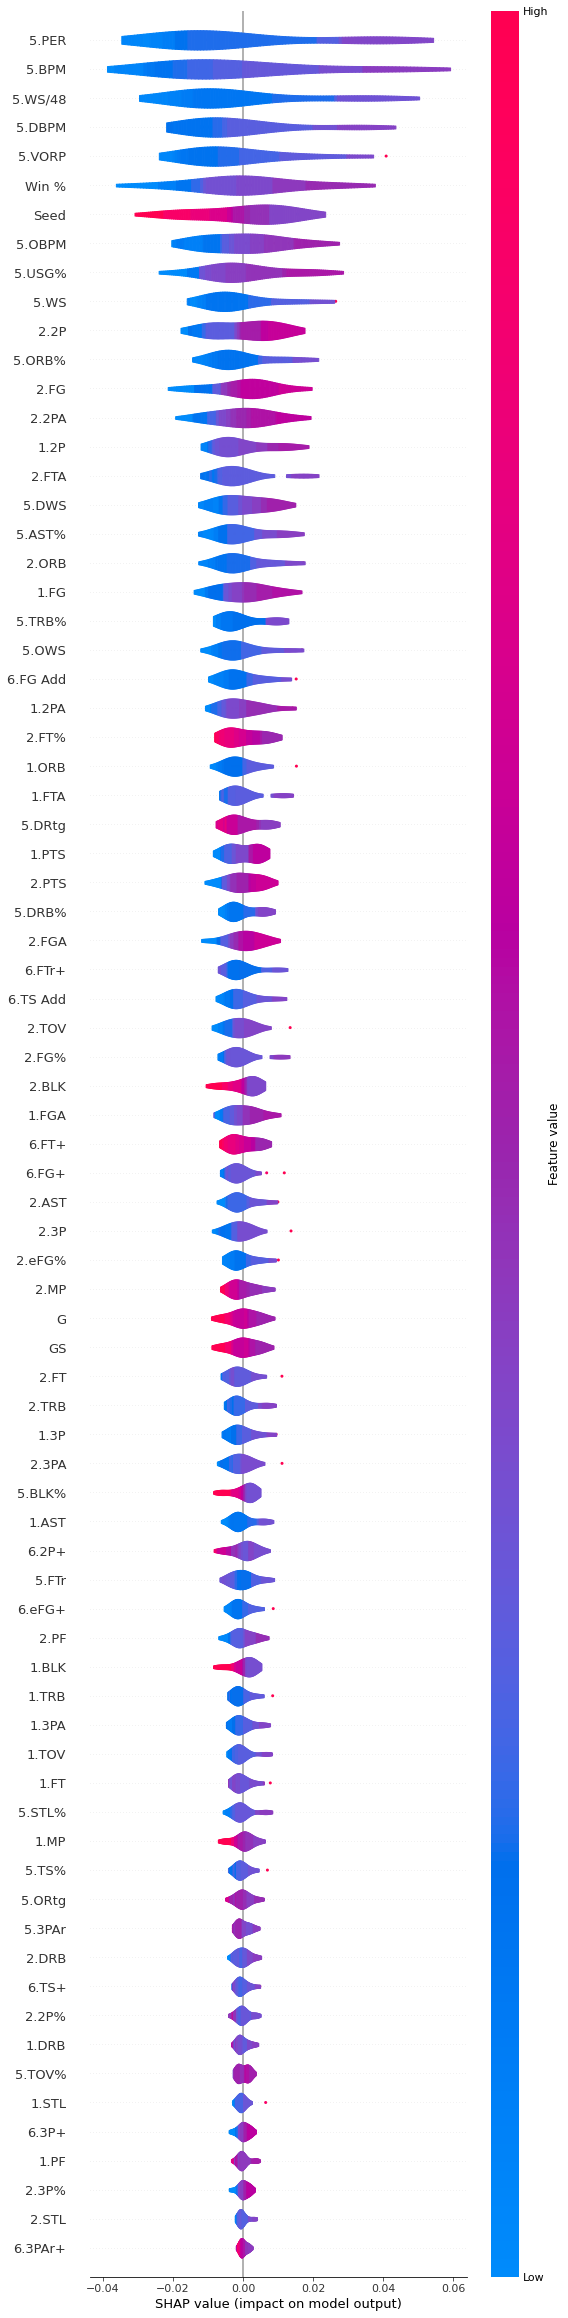

In [22]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns ,plot_type='violin', max_display=len(X_test.columns))

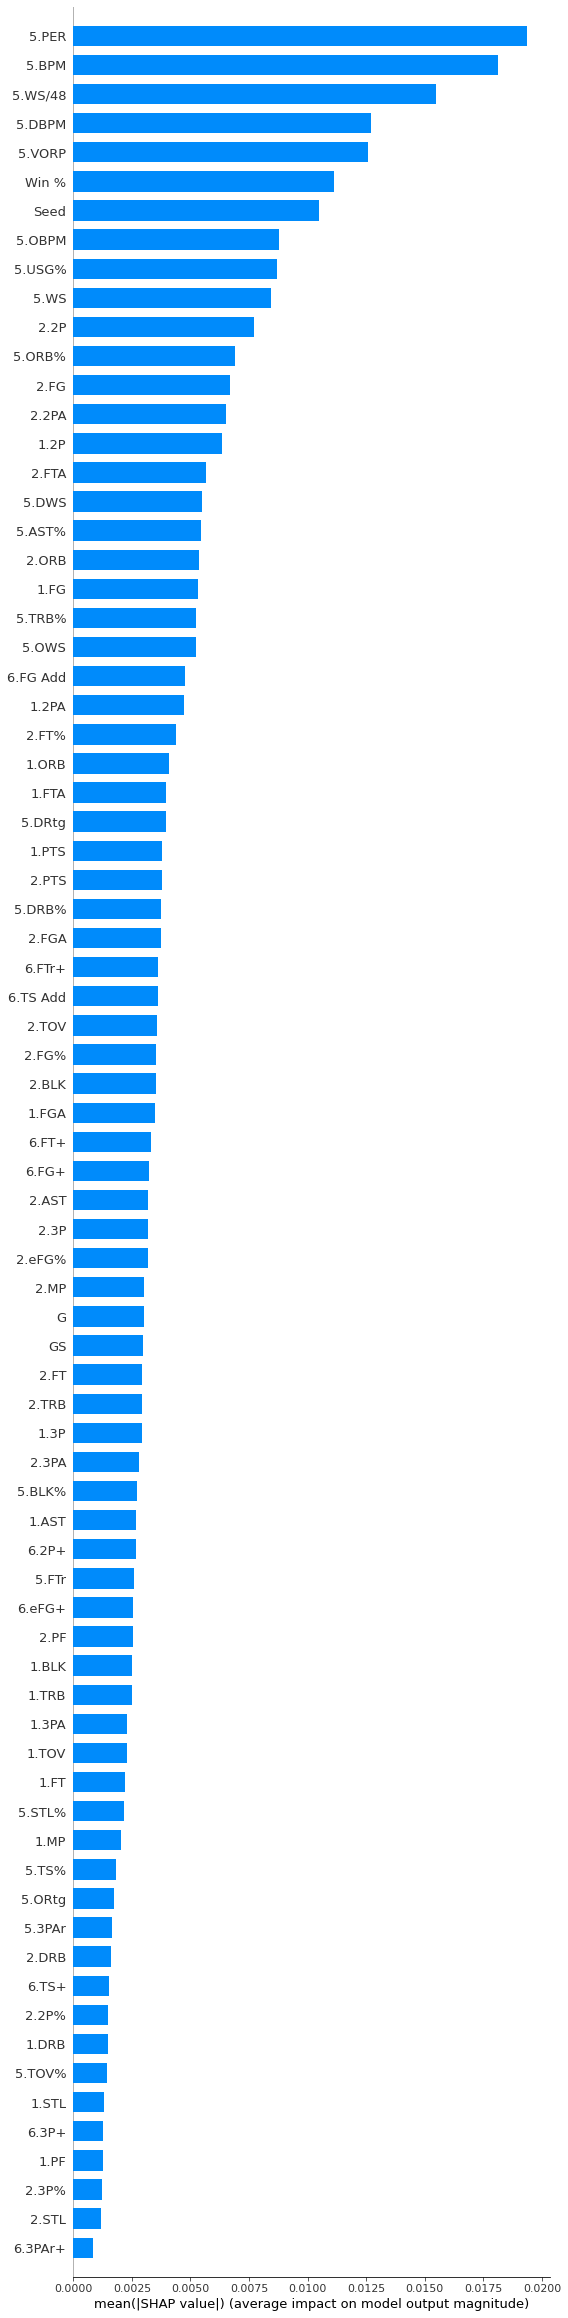

In [23]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns ,plot_type='bar', max_display=len(X_test.columns))